100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


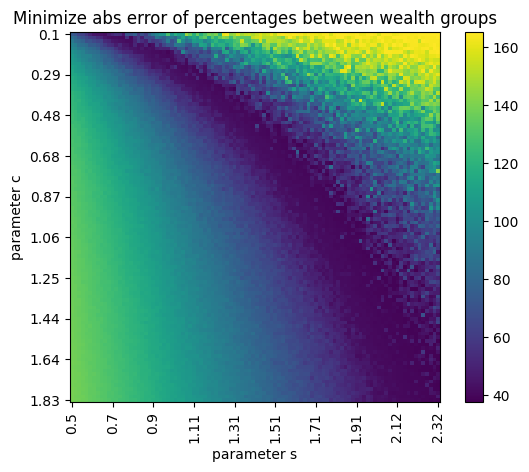

100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


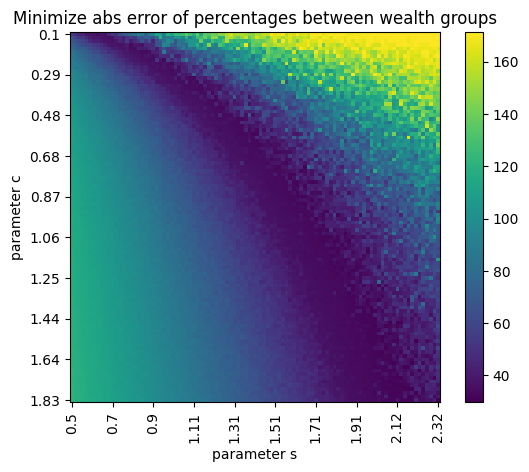

c:\Users\yoswald\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:1934: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
c:\Users\yoswald\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_distn_infrastructure.py:1934: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose in

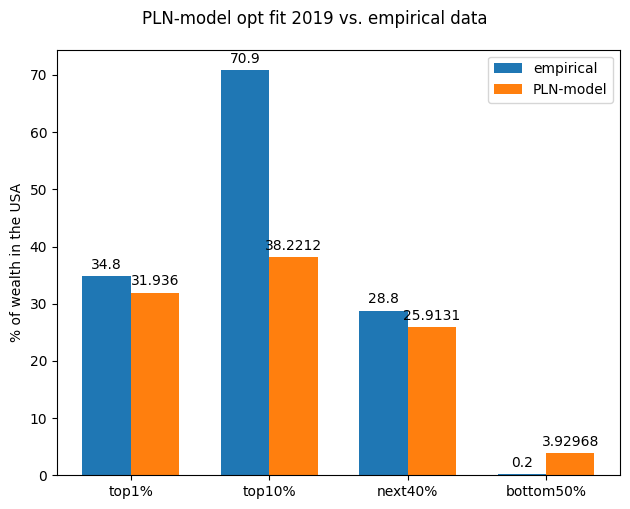

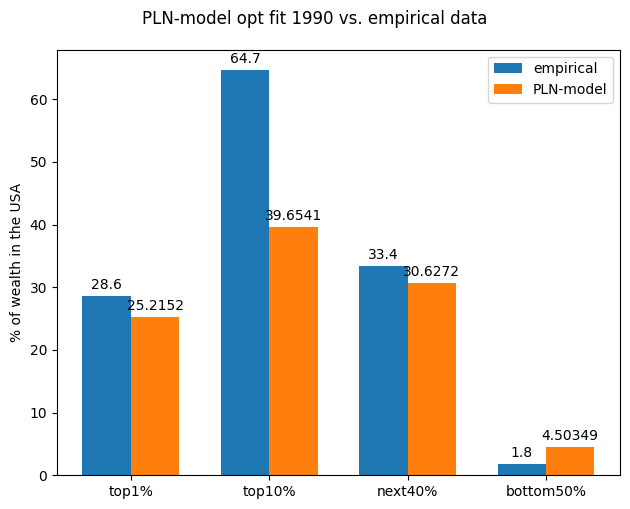

In [1]:
#Created on Tue Feb  7 13:59:25 2023

#@author: earyo

#In this script we fit a Pareto-lognormal distribution to the wealth distribution
#data in the USA from https://realtimeinequality.org/

import os
#os.chdir("C:/Users/earyo/Dropbox/Arbeit/postdoc_leeds/real_time_ineq_abm")
from inequality_metrics import find_wealth_groups2
import numpy as np
from scipy.stats import powerlognorm
from scipy.stats import genpareto
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm
#%%
### WEALTH GROUPS SHARE 01/2019 realtime-inequality.org
''' read some basic data'''
'''2019'''
### empirical wealth shares in the UNITED STATES in January 2019 for the
### top 1%, top10%, next40% and bottom 50% of wealth owners
empirical_wealth_shares = [34.8, 70.9, 28.8, 0.2]
#january 2019 average wealth per adult in $
average_US_wealth_per_adult = 410400
'''1990'''
### 1990 data is important so we can validate the model by 
### fitting it to the data from 1990 to 2019
####empirical wealth_shares for january 1990 [28.6, 64.7, 33.4, 1.8]
empirical_wealth_shares_1990 = [28.6, 64.7, 33.4, 1.8]
#january 1990 average wealth per adult in $
average_US_wealth_per_adult_1990 = 203900

#%%
def PLN_normalized(c, s, sample_size):   
    ''' samples the vector r from a powerlognorm distributuion and outputs the 
    top1%, top10%, next 40%, bottom 50%'''  
    ### This functions fits a power log-normal distribution to wealth data in the USA 
    ### Distribution and initial code taken from
    ### https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.powerlognorm.html#scipy.stats.powerlognorm
    mean, var, skew, kurt = powerlognorm.stats(c, s, moments='mvsk')
    r = powerlognorm.rvs(c, s, size=sample_size)
    w = find_wealth_groups2(r, sum(r))[1]
    w_percent = [x*100 for x in w]
    return w_percent, r, mean

def plot_wealth_groups(bars1, bars2): 
    ### plot wealth groups as barchart against each other  
    labels = ['top1%', 'top10%', 'next40%', 'bottom50%']
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, bars1, width, label='empirical')
    rects2 = ax.bar(x + width/2, bars2, width, label='PLN-model')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('% of wealth in the USA')
    ax.set_xticks(x, labels)
    ax.legend()
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    fig.tight_layout()
    return fig
    
def optimal_fit_PLN(c_range, s_range, sample_size, empirical_distr):
    """optimally fit Pareto-log-normal distr.to the data"""
    ## define local variables 
    q = empirical_distr
    result_range = np.zeros((len(c_range),len(s_range)))
    for i in tqdm(range(len(c_range))):
        for j in range(len(s_range)):
            ####sample from distrbution
            r = powerlognorm.rvs(c_range[i], s_range[j], size=sample_size)
            ### find wealth groups using the find wealth groups2 fct which
            ### returns a nested list where the second element, so idx = 1, is 
            ### the wealth shares in percent
            w = find_wealth_groups2(r, sum(r))[1]
            ### express wealth groups in percentage terms
            z = [x*100 for x in w]
            #print(z)
            #print(q)
            ### minimize based on absolute distance 
            minimization_fct = sum([abs(z[x] - q[x]) for x in range(0, 4)])
            #print(minimization_fct)
            #print(c_range[i],s_range[j], minimization_fct)
            result_range[i,j] = minimization_fct    
    return result_range


def optimal_fit_GP(eta_range, sample_size, empirical_distr):
    
    """optimally fit generalized pareto distribution to the data"""
    ## define local variables
    q = empirical_distr
    result_range = np.zeros((len(eta_range)))
    for i in tqdm(range(len(eta_range))):
        r = genpareto.rvs(eta_range[i], size=sample_size)
        w = find_wealth_groups2(r, sum(r))[1]
        ### express wealth groups in percentage terms
        z = [x*100 for x in w]
        #print(z)
        #print(q)
        ### minimize based on absolute distance 
        minimization_fct = sum([abs(z[x] - q[x]) for x in range(0, 4)])
        #print(minimization_fct)
        #print(c_range[i],s_range[j], minimization_fct)
        result_range[i] = minimization_fct    
    return result_range



##https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap
def heatmap2d(arr, xticks, yticks):
        plt.imshow(arr, cmap='viridis')
        plt.title('Minimize abs error of percentages between wealth groups')
        plt.colorbar()
        plt.xlabel("parameter s")
        plt.ylabel("parameter c")
        plt.xticks(np.linspace(0,99,10), yticks, rotation = "vertical")  # Set label locations.
        plt.yticks(np.linspace(0,99,10), xticks)  # Set label locations.        
        plt.show()


#%% 
#### define parameter range  that is to be searched over for an optimum/min.
c_range_data = np.around(np.linspace(0.1, 2, 100),2)
s_range_data = np.around(np.linspace(0.5, 2.5, 100),2)
sample_size = 10**4
#%% RUN ERROR MINIMIZATION for 2019 (January)
### minimize based on absolute distance 
#result_range_fct2 = np.zeros((100,100))
results = optimal_fit_PLN(c_range_data, 
                          s_range_data,
                          sample_size,
                          empirical_wealth_shares)
optimal_c = c_range_data[np.where(results == np.min(results))[0][0]]   
optimal_s = s_range_data[np.where(results == np.min(results))[1][0]]
c_range_ticks = list(c_range_data)[::10]
s_range_ticks = list(s_range_data)[::10]
heatmap2d(results, c_range_ticks, s_range_ticks)

#%% RUN ERROR MINIMIZATION for 1990 January
results_1990 = optimal_fit_PLN(c_range_data,
                               s_range_data,
                               sample_size,
                               empirical_wealth_shares_1990)
results_1990[np.where(c_range_data==1.04) , np.where(s_range_data==1.95)]
optimal_c_1990 = c_range_data[np.where(results_1990 == np.min(results_1990))[0][0]]   
optimal_s_1990 = s_range_data[np.where(results_1990 == np.min(results_1990))[1][0]]
heatmap2d(results_1990, c_range_ticks, s_range_ticks)

#%% PLOT GROUPS vs. empirical for 2019
sampled_distr = PLN_normalized(0.33, 1.15, sample_size)
groups_modelled, raw_sample, mean = sampled_distr[0], sampled_distr[1], sampled_distr[2]
plot1 = plot_wealth_groups(empirical_wealth_shares, groups_modelled)
plot1.suptitle("PLN-model opt fit 2019 vs. empirical data",  y=1.05)

#%% PLOT GROUPS vs. empirical for 1990
sampled_distr2 = PLN_normalized(1.92, 2.08, sample_size)
groups_modelled2, raw_sample2, mean2 = sampled_distr2[0], sampled_distr2[1], sampled_distr2[2]
plot2 = plot_wealth_groups(empirical_wealth_shares_1990, groups_modelled2)
plot2.suptitle("PLN-model opt fit 1990 vs. empirical data",  y=1.05)

#%% FIND THE PROPER SCALE COEFFICIENTS
#### NEEDS TO BE FURTHER OPTIMITZED LATER CODE ALSO
import numpy as np
from scipy.stats import powerlognorm
scale_coeff = 150000
sample_size = 1000000
##distribution for 1990
sample = powerlognorm.rvs(1.92, 2.08, size=sample_size)*scale_coeff
sample = np.flip(np.sort(sample))


total_average = np.mean(sample)
top1_average = np.mean(sample[:int(0.01*sample_size)])
top10_average = np.mean(sample[:int(0.1*sample_size)])
next40_average = np.mean(sample[int(0.1*sample_size):int(0.5*sample_size)])
bottom50_average = np.mean(sample[int(0.5*sample_size):])


